# 2020-07-29 • Spike-triggered averaging

## Imports & time grid

In [1]:
%run init.ipynb

Importing np, mpl, plt … ✔
Importing unyt … ✔
Importing code package (voltage_to_wiring_sim), as `v` … ✔
Imported * from v.util and from v.units


In [2]:
tg = v.TimeGrid(T=10*min, dt=0.1*ms)

## Spike trains

'Network' definition.

In [64]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

Have all incoming neurons spike with the same mean frequency, for now.

In [65]:
f_spike = 20 * Hz

In [66]:
gen_st = v.generate_Poisson_spike_train

fix_rng_seed()

In [67]:
%%time
spike_trains_connected = [gen_st(tg, f_spike) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(tg, f_spike) for _ in range(N_unconnected)]

Wall time: 2.13 s


This takes a while.\
Most time is spent in numpy's `random()`, which is a highly optimized function. Ergo, the implementation of the algorithm is not to blame.

We could cache spike trains.

Or, we could maybe directly generate spike times (instead of looping over all timebins), with sampling from `uniform(0, T)`. This should also generate Poisson spike trains, no? #todo: check

In [68]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected

Inspect a time excerpt..

In [69]:
time_slice = 1 * min + [0, 1] * s

slice_indices = np.round(time_slice / tg.dt).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.t[i_slice].in_units(s)

..of one presynaptic neuron:


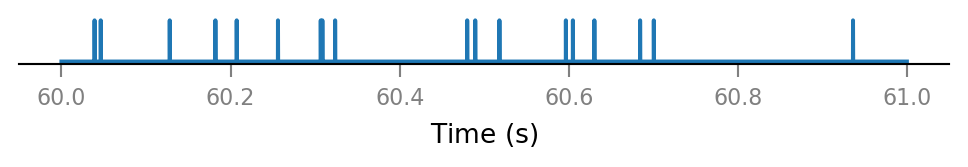

In [70]:
v.spike_train.plot(t_slice, all_spike_trains[0][i_slice]);

All connected presynaptic neurons:

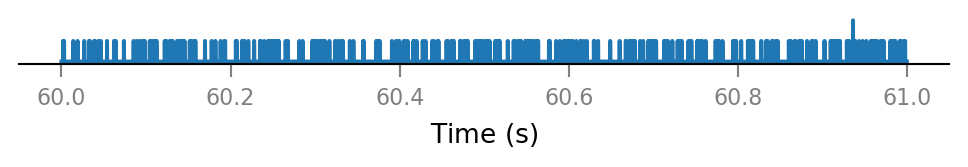

In [71]:
all_incoming_spikes = sum(spike_trains_connected)

v.spike_train.plot(t_slice, all_incoming_spikes[i_slice]);

## Synaptic conductance

Also see the previous notebook {doc}`/notebooks/2020-07-27__Synaptic_conductances`.

In [77]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms

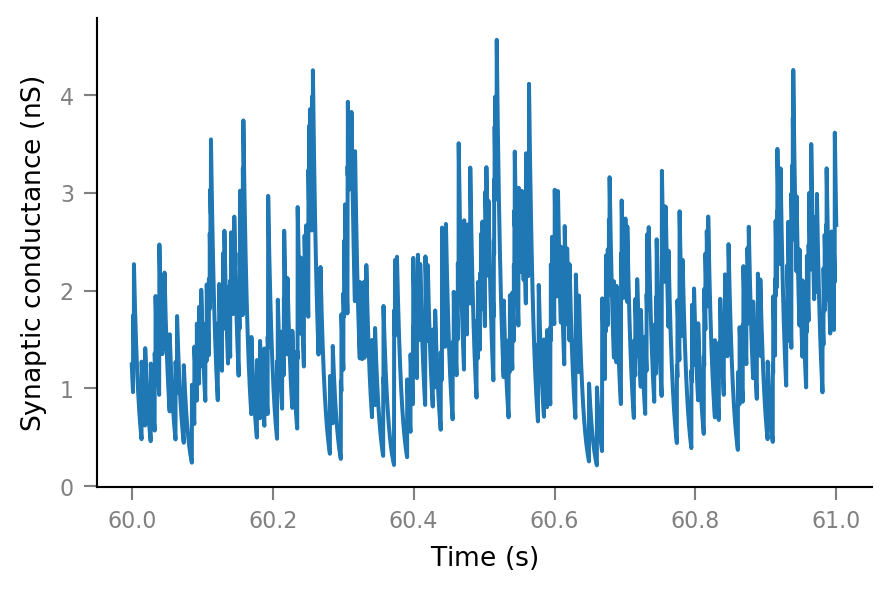

In [78]:
g_syn = v.calc_synaptic_conductance(
    tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice]);

## Membrane voltage

In [79]:
params = v.params.cortical_RS
print(params)

IzhikevichParams
----------------
C = 100 pF
k = 0.7 nS/mV
v_r = -60 mV
v_t = -40 mV
v_peak = 35 mV
a = 0.03 1/ms
b = -2 nS
c = -50 mV
d = 100 pA
v_syn = 0 mV


In [80]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 462 ms


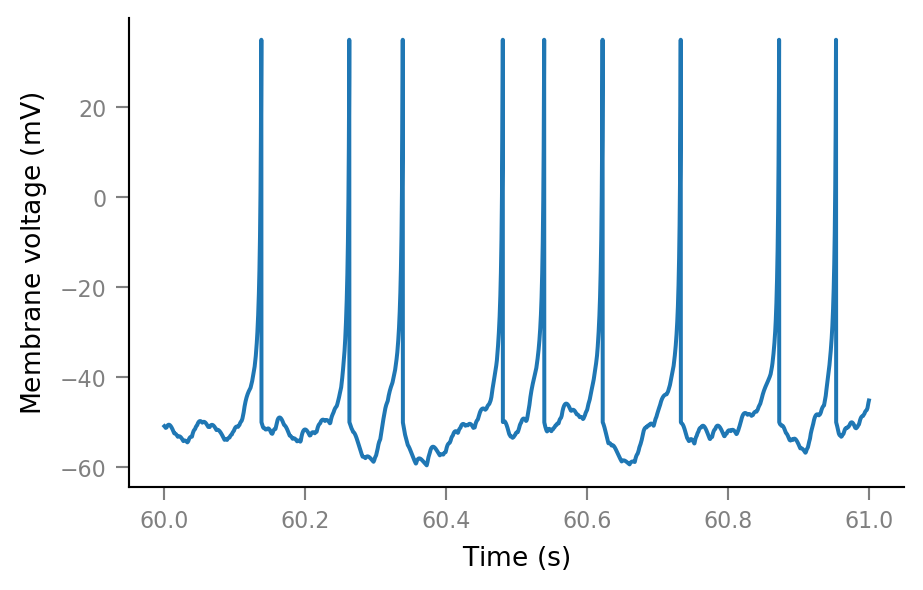

In [81]:
plt.plot(t_slice, sim.V_m[i_slice]);

## Noise

As in {doc}`/notebooks/2020-07-06__Single_neuron_sim`.

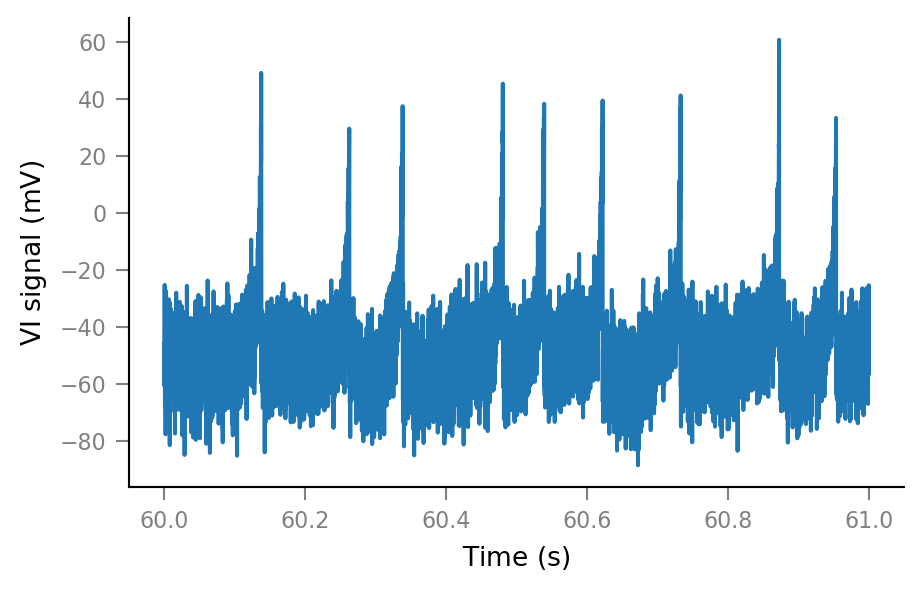

In [82]:
SNR = 10
spike_height = params.v_peak - params.v_r

σ_noise = spike_height / SNR
noise = np.random.randn(tg.N) * σ_noise

Vm_noisy = (sim.V_m + noise).in_units(mV)
Vm_noisy.name = 'VI signal'

plt.plot(t_slice, Vm_noisy[i_slice]);

## Spike-triggered windows

In [83]:
def get_spike_indices(spike_train):
    # `nonzero` returns a tuple (one element for each array dimension).
    (spike_indices,) = np.nonzero(spike_train)  
    return spike_indices

Test with one spike train

In [117]:
spike_train__example = all_spike_trains[0]
spike_indices__example = get_spike_indices(spike_train__example)
num_spikes__example = len(spike_indices__example)
num_spikes__example

12020

Spiking frequency for this presynaptic neuron:

In [118]:
print(Quantity(num_spikes__example / tg.T, Hz))

20.03 Hz


That's to spec.

Extract windows from the VI signal.

In [105]:
window_length = 100 * ms

window_tg = v.TimeGrid(window_length, tg.dt)
window_tg.t.name = "Time after spike"

def make_windows(spike_indices):
    windows = []
    for ix in spike_indices:
        ix_end = ix + window_tg.N
        if ix_end < tg.N:
            windows.append(Vm_noisy[ix:ix_end])
    
    windows = np.stack(windows)
    return Array(windows, V, name=Vm_noisy.name).in_units(mV)
        
windows__example = make_windows(spike_indices__example)
windows__example.shape

(12019, 1000)

Note that there are generally a few less windows than spikes. This happens when the last few spikes occur too close to the end of the simulation to fit complete windows after them.

An example spike-triggered window:

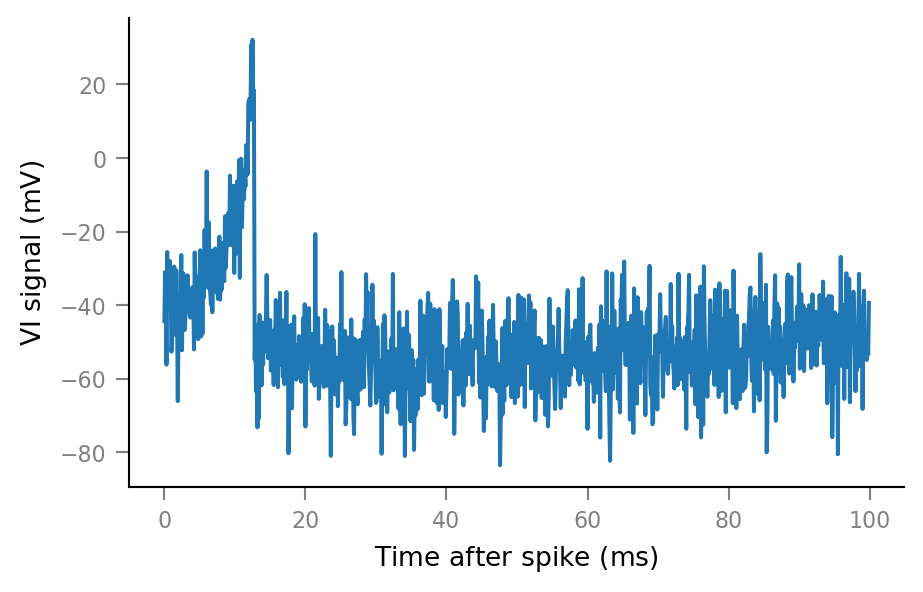

In [155]:
plt.plot(window_tg.t, windows[0,:]);

And some more:

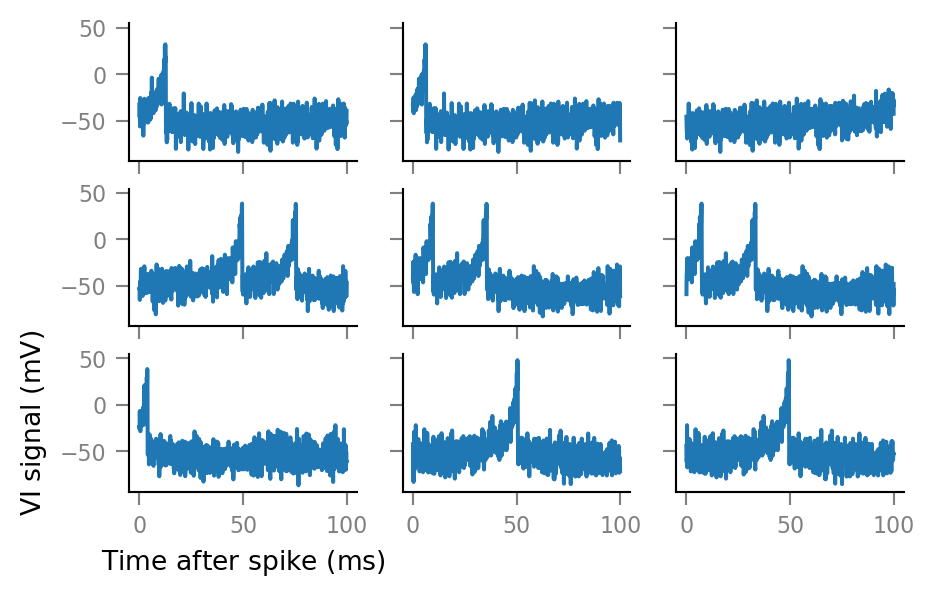

In [169]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

for row, row_axes in enumerate(axes):
    for col, ax in enumerate(row_axes):
        i = 3*row + col
        ax.plot(window_tg.t, windows[i,:])
        if not(row == 2 and col == 0):
            ax.set(xlabel=None, ylabel=None)

## Average windows

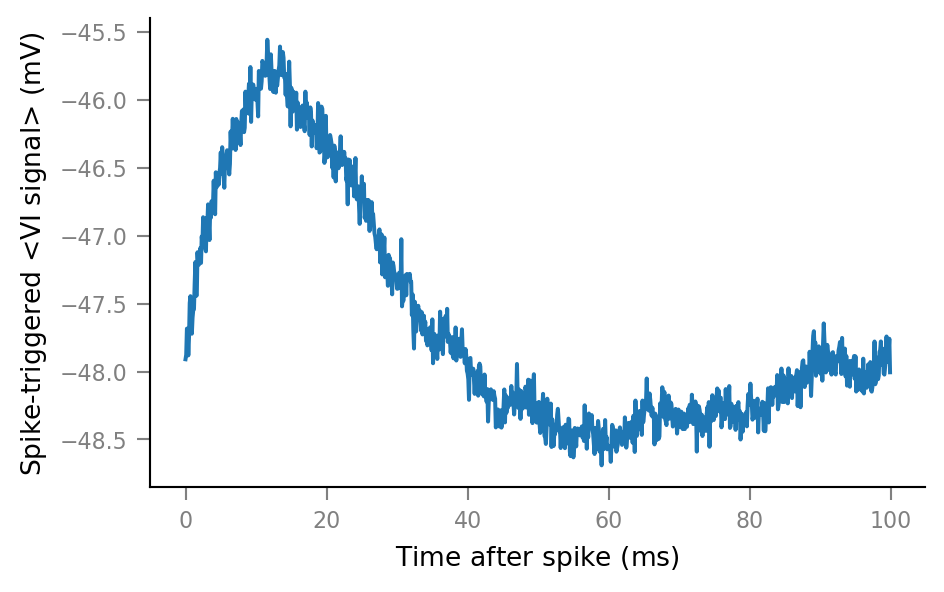

In [87]:
def STA(spike_train):
    spike_indices = get_spike_indices(spike_train)
    windows = make_windows(spike_indices)
    STA = windows.mean(axis=0)
    return Array(STA, V, name="Spike-triggered <VI signal>").in_units(mV)

def plot_STA(spike_train, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(window_tg.t, STA(spike_train), **kwargs)
    
plot_STA(spike_trains_connected[0])

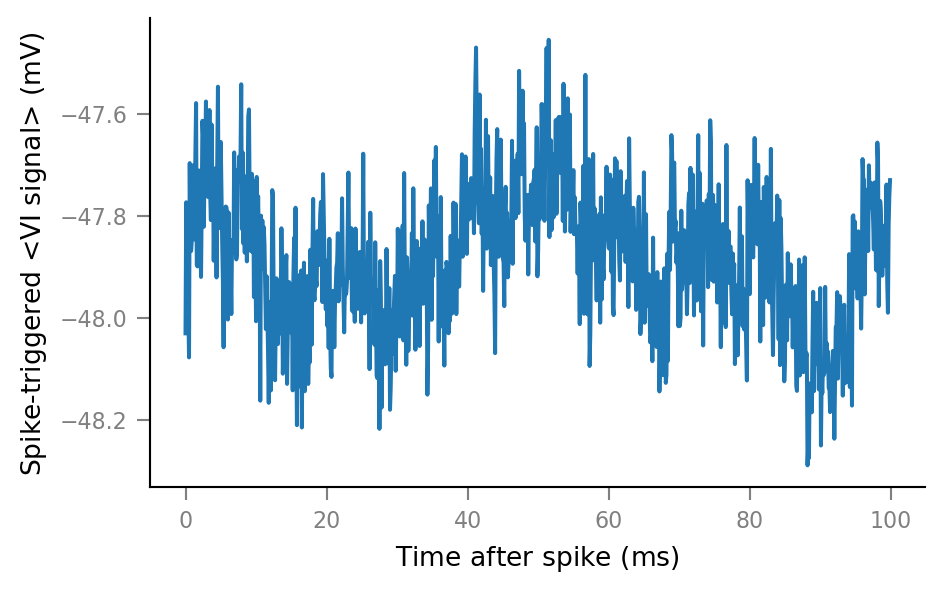

In [88]:
plot_STA(spike_trains_unconnected[0])

## Plot average windows of all spike trains

In [89]:
%%time

fig, ax = plt.subplots()

for spike_train in spike_trains_connected:
    plot_STA(spike_train, ax, alpha=0.2, color='C0')

for spike_train in spike_trains_unconnected:
    plot_STA(spike_train, ax, alpha=0.2, color='C1')
    
plt.close()

Wall time: 8.28 s


(Again, takes a while. Might possibly be sped up using [LineCollection](https://matplotlib.org/3.1.1/api/collections_api.html#matplotlib.collections.LineCollection)).

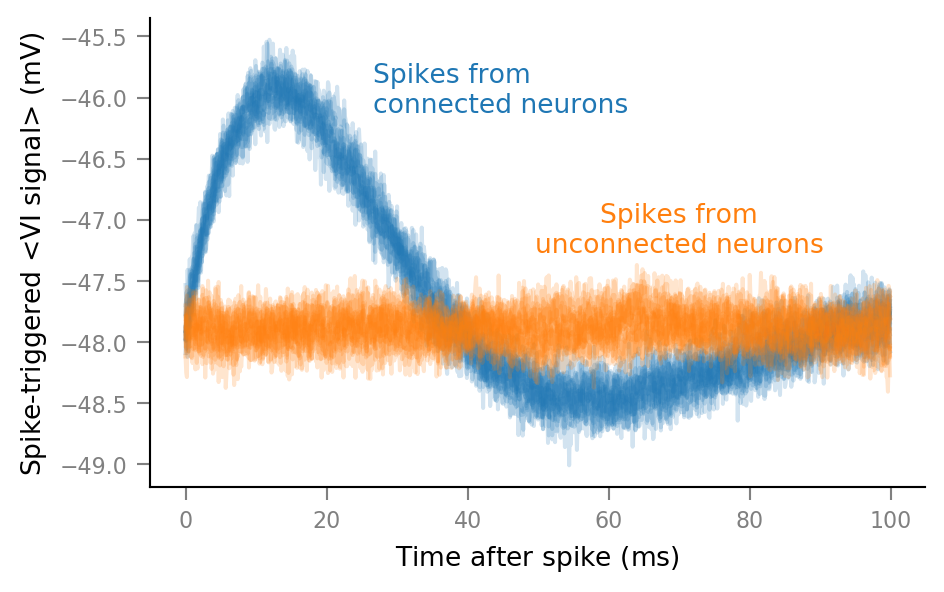

In [99]:
# Clear existing texts, for iterative positioning.
for _ in range(len(ax.texts)):
    ax.texts.pop()

ax.annotate("Spikes from\nconnected neurons",
            xy=(26.55*ms, 0.8), xycoords=('data', 'axes fraction'),
            color="C0", ha="left")

ax.annotate("Spikes from\nunconnected neurons",
            xy=(70*ms, 0.5), xycoords=('data', 'axes fraction'),
            color="C1", ha="center")

fig

Next steps: describe influence of `N_in`, `p_connected`, `SNR`, ..